# GAN Models

As part of the learning of generative models, GAN was the most popular models before diffusion models came out. The advantage of the GAN model is the easiness of construction. It was widely used to generate new data (image, videos...). 

In [2]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn

from torchinfo import summary
import torchsummary

import torch.utils.data as utils

import matplotlib.pyplot as plt
import numpy as np

## Data preparation
### use MNIST data

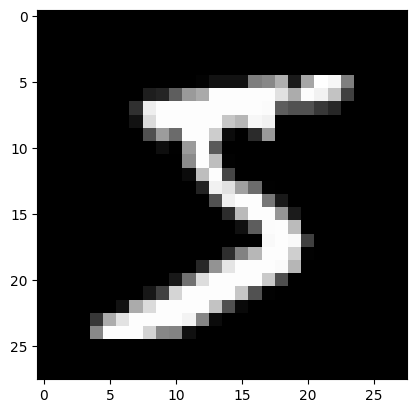

In [45]:
dataset = datasets.MNIST("./mnist", download=False, transform=transforms.ToTensor())
img, label = dataset[0]
plt.imshow(img[0,:,:], cmap="gray")

In [4]:
# divide the dataset to train and valid
# function to divide the indices
def divide_dataset(n, ratio=0.1) :
    indices = torch.randperm(n)
    train_inds = int(n * ratio)
    return indices[0:train_inds], indices[train_inds:]

train_inds, valid_inds = divide_dataset(len(dataset), ratio=0.8)
print(len(train_inds), len(train_inds))

48000 48000


In [6]:
batch_size = 200
# data samplers
train_sampler = utils.SubsetRandomSampler(train_inds)
valid_sampler = utils.SubsetRandomSampler(valid_inds)
# dataloaders
train_loader = utils.DataLoader(dataset=dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader = utils.DataLoader(dataset=dataset, batch_size=batch_size, sampler=valid_sampler)

# GAN

GAN composes of a generator and a discriminator. The generator generates data from some latent attributes and the discriminator serves as a classifier to evaluate the outputs of the generator. The 2 models was trained in a competative fashion and improve altogether. The loss function is evaluated by the output of the discriminator and the backpropagations are done separately.

In [17]:
# GAN model

class Discriminator (nn.Module) :

    def __init__(self):
        
        super().__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(1, 32, (3,3), stride=1, padding=1),
            nn.Conv2d(32, 32, (3,3), stride=1,padding=1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d((2,2), stride=2),
            
            nn.Conv2d(32, 64, (3,3), stride=1, padding=1),
            nn.Conv2d(64, 64, (3,3), stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d((2,2), stride=2),

            nn.Flatten(),
            nn.Linear(64*7*7, 1),
            nn.Sigmoid()
        )

    def forward(self, input):

        dis = self.discriminator(input)
        
        return dis


class Generator (nn.Module) :

    def __init__(self) :
        super().__init__()
        self.latent_dim = 64
        self.generator = nn.Sequential(

            nn.Linear(self.latent_dim, 7 * 7 * 16),
            nn.Unflatten(1, (16, 7, 7)),
            nn.ConvTranspose2d(16, 32, (4,4), stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 64, (4,4), stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 1, (3,3), stride=1, padding=1),
            nn.Sigmoid()
            
        )
  
    def forward(self, input) :
        
        gen = self.generator(input)
        return gen


#batch_size = 16

torchsummary.summary(Discriminator(), input_size=(1, 28, 28))

summary(Generator(), input_size=(batch_size, 64)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 32, 28, 28]           9,248
         LeakyReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          18,496
            Conv2d-6           [-1, 64, 14, 14]          36,928
         LeakyReLU-7           [-1, 64, 14, 14]               0
         MaxPool2d-8             [-1, 64, 7, 7]               0
           Flatten-9                 [-1, 3136]               0
           Linear-10                    [-1, 1]           3,137
          Sigmoid-11                    [-1, 1]               0
Total params: 68,129
Trainable params: 68,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

Layer (type:depth-idx)                   Output Shape              Param #
generator                                [100, 1, 28, 28]          --
├─Sequential: 1-1                        [100, 1, 28, 28]          --
│    └─Linear: 2-1                       [100, 784]                50,960
│    └─Unflatten: 2-2                    [100, 16, 7, 7]           --
│    └─ConvTranspose2d: 2-3              [100, 32, 14, 14]         8,224
│    └─LeakyReLU: 2-4                    [100, 32, 14, 14]         --
│    └─ConvTranspose2d: 2-5              [100, 64, 28, 28]         32,832
│    └─LeakyReLU: 2-6                    [100, 64, 28, 28]         --
│    └─Conv2d: 2-7                       [100, 1, 28, 28]          577
│    └─Sigmoid: 2-8                      [100, 1, 28, 28]          --
Total params: 92,593
Trainable params: 92,593
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 2.79
Input size (MB): 0.03
Forward/backward pass size (MB): 46.41
Params size (MB): 0.37
Estimated Total Siz

In [32]:
# training

dis = Discriminator()
gen = Generator()

epochs = 10
lr = 0.001

loss_fn_dis = nn.BCELoss()
loss_fn_gen = nn.BCELoss()

optimizer_dis = torch.optim.Adam(dis.parameters(), lr=lr)
optimizer_gen = torch.optim.Adam(gen.parameters(), lr=lr)

for e in range(epochs) :

    gen_loss_tot = 0
    dis_loss_tot = 0

    for data, _ in train_loader:

        # run generator forward
        
        latent_data = torch.randn(batch_size, gen.latent_dim)
        
        output = gen(latent_data)
        labels = torch.cat((torch.zeros(batch_size,1), torch.ones(batch_size,1)))
        
        # train discriminator
        train_data = torch.cat((output, data), 0)
        
        preds = dis(train_data)
        
        loss_dis = loss_fn_dis(preds, labels)

        # backpropagate discriminator
        optimizer_dis.zero_grad()
        loss_dis.backward()
        optimizer_dis.step()

        dis_loss_tot += loss_dis
        
        # train generator
        labels = torch.ones(batch_size,1)
        
        preds = dis(gen(latent_data))
        loss_gen = loss_fn_gen(preds, labels)

        # backpropagate generator
        optimizer_gen.zero_grad() 
        loss_gen.backward()
        optimizer_gen.step()

        gen_loss_tot += loss_gen

    print("Epoch {} / {} : gen_loss: {}, dis_loss : {}". \
          format(e+1, epochs, gen_loss_tot/len(train_loader), dis_loss_tot/len(train_loader)))

# the more the training epochs, the better the result.

Epoch 1 / 10 : gen_loss: 3.889908790588379, dis_loss : 0.6149267554283142
Epoch 2 / 10 : gen_loss: 2.519575595855713, dis_loss : 0.3167060613632202
Epoch 3 / 10 : gen_loss: 2.3556067943573, dis_loss : 0.3277251124382019
Epoch 4 / 10 : gen_loss: 2.0848464965820312, dis_loss : 0.36179351806640625
Epoch 5 / 10 : gen_loss: 2.2532119750976562, dis_loss : 0.3411913216114044
Epoch 6 / 10 : gen_loss: 2.5054848194122314, dis_loss : 0.3025457561016083
Epoch 7 / 10 : gen_loss: 2.8628337383270264, dis_loss : 0.2631157636642456
Epoch 8 / 10 : gen_loss: 3.012570381164551, dis_loss : 0.24077989161014557
Epoch 9 / 10 : gen_loss: 2.879523992538452, dis_loss : 0.2536063492298126
Epoch 10 / 10 : gen_loss: 2.814591407775879, dis_loss : 0.25203436613082886


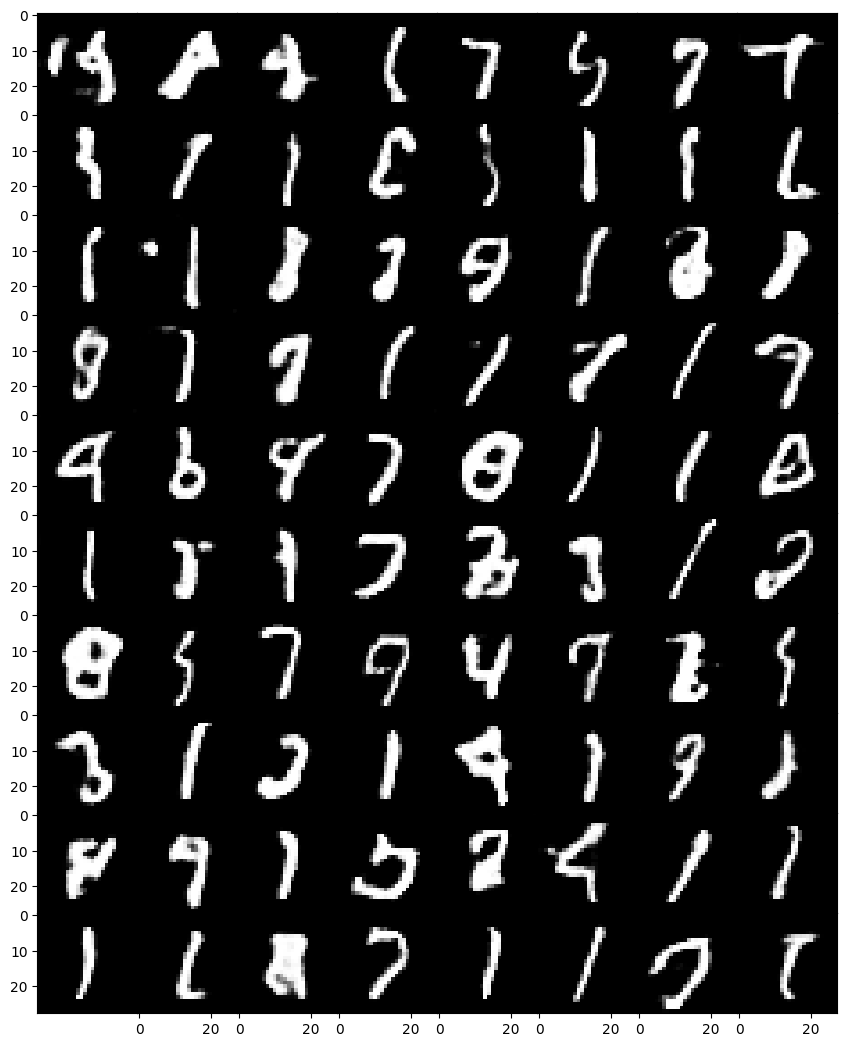

In [33]:
# test on trained GAN
nCol = 8
nRow = 10
fig, ax = plt.subplots(nRow, nCol, gridspec_kw=dict(wspace=0.0, hspace=0.0, \
                     top=1. - 0.5 / (nRow + 1), bottom=0.5 / (nRow + 1), \
                     left=0.5 / (nCol + 1), right=1 - 0.5 / (nCol + 1)), \
                    figsize=(nCol + 1, nRow + 1),
                    sharey='row', sharex='col', #  optionally
                      )
for i in range(nRow):
    for j in range(nCol):
        latent_data = torch.randn(1, gen.latent_dim)
        im = gen(latent_data).detach().numpy()
        ax[i, j].imshow(im[0,0,:,:], cmap="gray")
        ax[i, 0].get_xaxis().set_visible(False)

## CGAN

This is a naive approach for CGAN, where the condition (here is a integer denoting the image label) is added to the latent space of the generator. However, the result showed that this approach doesn't work since the condition seems have no effect on the generated images. So I added also the condition to the input of the discriminator, and the result seems promising.

In [19]:
# position embedding object borrowed from transformer paper

class PosEmbed(nn.Module) :

    def __init__(self, dim, n=10000) :
        
        super().__init__()
        self.dim = dim
        self.n = n

    @staticmethod
    def posEmbedding(t, size, n=10000):
        # size is the total mebedding unit number, with each unit denoted by ind i
        # t has size (batch, 1)
        embeds = torch.zeros((t.shape[0], size)) # size (batch, size)
        
        pe = np.array([1/(n**(2*i/size)) for i in range(0,size,2)])
        
        for i, pos in enumerate(t):
            embeds[i, 0: :2] = np.sin(pos / pe)
            embeds[i, 1: :2] = np.cos(pos / pe)
        
        return embeds

    def forward(self, x) :
        return self.posEmbedding(x, self.dim, self.n).requires_grad_(False)


In [33]:
# CGAN model

class CDiscriminator (nn.Module) :

    def __init__(self, num_class=10):
        
        super().__init__()

        self.num_class = num_class

        self.label_embed = nn.Sequential(
            PosEmbed(64), # (batch, embed_dim)
            nn.Linear(64, 28*28), # (batch, out_ch)
            nn.SiLU()
        )

        self.discriminator = nn.Sequential(
            nn.Conv2d(2, 32, (3,3), stride=1, padding=1),
            nn.Conv2d(32, 32, (3,3), stride=1,padding=1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d((2,2), stride=2),
            
            nn.Conv2d(32, 64, (3,3), stride=1, padding=1),
            nn.Conv2d(64, 64, (3,3), stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d((2,2), stride=2),

            nn.Flatten(),
            nn.Linear(64*7*7, 1),
            nn.Sigmoid()
        )

    def forward(self, input, label):

        emb = self.label_embed(label)
        emb = emb.view(-1, 1, 28, 28)

        dis = torch.concat((input, emb), dim=1)

        dis = self.discriminator(dis)
        
        return dis


class CGenerator (nn.Module) :

    def __init__(self, num_class=10) :
        super().__init__()
        self.latent_dim = 64
        self.num_class = num_class
        
        #self.embedding = nn.Embedding(num_class, 64)
        self.linear_embedding = nn.Linear(64, 7*7)
        
        self.linear_img = nn.Linear(self.latent_dim, 7 * 7 * 16)

        self.label_embed = nn.Sequential(
            PosEmbed(self.latent_dim), # (batch, embed_dim)
            nn.Linear(64, 7*7), # (batch, out_ch)
            nn.SiLU()
        )
        
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(17, 32, (4,4), stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 64, (4,4), stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 1, (3,3), stride=1, padding=1),
            nn.Sigmoid()
            
        )
  
    def forward(self, input, label) :

        #emb = self.embedding(label.to(torch.int64))
        #emb = self.linear_embedding(emb)
        emb = self.label_embed(label)
        emb = emb.view(-1, 1, 7, 7)

        gen = self.linear_img(input)
        gen = gen.view(-1, 16, 7, 7)

        gen = torch.concat((gen, emb), dim=1)
        
        gen = self.generator(gen)
        return gen


#batch_size = 16

#torchsummary.summary(CDiscriminator(), input_size=[(1, 28, 28), (1,1)])
summary(CGenerator(), input_size=[(batch_size, 64), (batch_size, 1)]) 
torchsummary.summary(CGenerator(), input_size=[(1, 64), (1,1)]) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          PosEmbed-1                   [-1, 64]               0
            Linear-2                   [-1, 49]           3,185
              SiLU-3                   [-1, 49]               0
            Linear-4               [-1, 1, 784]          50,960
   ConvTranspose2d-5           [-1, 32, 14, 14]           8,736
         LeakyReLU-6           [-1, 32, 14, 14]               0
   ConvTranspose2d-7           [-1, 64, 28, 28]          32,832
         LeakyReLU-8           [-1, 64, 28, 28]               0
            Conv2d-9            [-1, 1, 28, 28]             577
          Sigmoid-10            [-1, 1, 28, 28]               0
Total params: 96,290
Trainable params: 96,290
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.88
Params size (MB): 0.37
Estimated Tot

In [46]:
# training
epochs = 50
if False:

    cdis = CDiscriminator()
    cgen = CGenerator()
    
    lr = 0.0001
    
    loss_fn_cdis = nn.BCELoss()
    loss_fn_cgen = nn.BCELoss()
    
    optimizer_cdis = torch.optim.Adam(cdis.parameters(), lr=lr)
    optimizer_cgen = torch.optim.Adam(cgen.parameters(), lr=lr)

for e in range(epochs) :

    gen_loss_tot = 0
    dis_loss_tot = 0

    for data, label in train_loader:

        # run generator forward
        
        latent_data = torch.randn(batch_size, cgen.latent_dim)
        
        output = cgen(latent_data, label)
        
        labels = torch.cat((torch.zeros(batch_size,1), torch.ones(batch_size,1)))
        
        # train discriminator
        train_data = torch.cat((output, data), 0)
        train_categ = torch.cat((label, label), 0)
        
        preds = cdis(train_data, train_categ)
        
        #print(labels.shape, train_data.shape, preds.shape)
        
        loss_dis = loss_fn_cdis(preds, labels)
        
        optimizer_cgen.zero_grad()
        optimizer_cdis.zero_grad()
        loss_dis.backward()
        optimizer_cdis.step()

        dis_loss_tot += loss_dis
        
        # train generator
        labels = torch.ones(batch_size,1)
        
        preds = cdis(cgen(latent_data, label), label)
        loss_gen = loss_fn_cgen(preds, labels)
        
        optimizer_cgen.zero_grad() 
        optimizer_cdis.zero_grad() 
        loss_gen.backward()
        optimizer_cgen.step()
        
        #print(loss_dis.item(), loss_gen.item())

        gen_loss_tot += loss_gen

    print("Epoch {} / {} : gen_loss: {}, dis_loss : {}". \
          format(e+1, epochs, gen_loss_tot/len(train_loader), dis_loss_tot/len(train_loader)))

Epoch 1 / 50 : gen_loss: 2.3372864723205566, dis_loss : 0.2720299959182739
Epoch 2 / 50 : gen_loss: 2.3833885192871094, dis_loss : 0.2604791522026062
Epoch 3 / 50 : gen_loss: 2.372727870941162, dis_loss : 0.26020678877830505
Epoch 4 / 50 : gen_loss: 2.3677759170532227, dis_loss : 0.2663016617298126
Epoch 5 / 50 : gen_loss: 2.423645496368408, dis_loss : 0.2556799054145813
Epoch 6 / 50 : gen_loss: 2.3429651260375977, dis_loss : 0.25372055172920227
Epoch 7 / 50 : gen_loss: 2.431654691696167, dis_loss : 0.26246801018714905
Epoch 8 / 50 : gen_loss: 2.3703408241271973, dis_loss : 0.2668493092060089
Epoch 9 / 50 : gen_loss: 2.348478078842163, dis_loss : 0.2809922993183136
Epoch 10 / 50 : gen_loss: 2.4242377281188965, dis_loss : 0.28582489490509033
Epoch 11 / 50 : gen_loss: 2.3028676509857178, dis_loss : 0.28974729776382446
Epoch 12 / 50 : gen_loss: 2.2594919204711914, dis_loss : 0.29257363080978394
Epoch 13 / 50 : gen_loss: 2.2526347637176514, dis_loss : 0.2964068055152893
Epoch 14 / 50 : gen

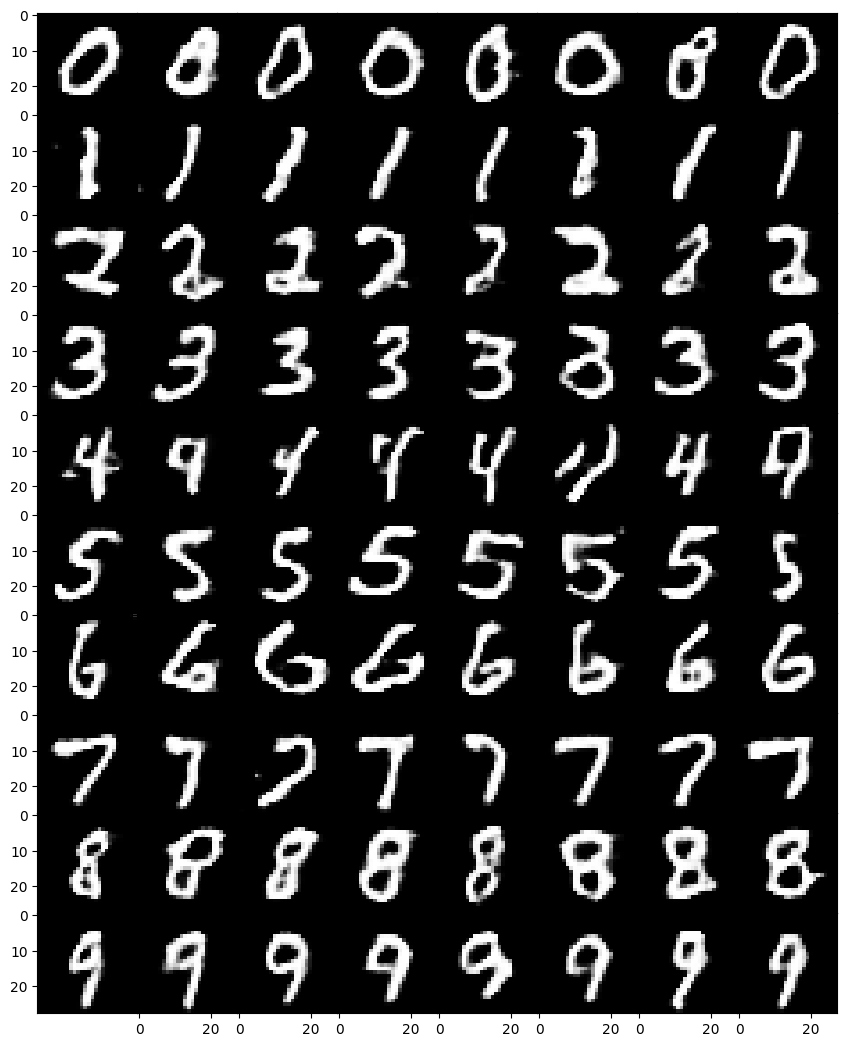

In [47]:
# test on trained GAN
nCol = 8
nRow = 10
fig, ax = plt.subplots(nRow, nCol, gridspec_kw=dict(wspace=0.0, hspace=0.0, \
                     top=1. - 0.5 / (nRow + 1), bottom=0.5 / (nRow + 1), \
                     left=0.5 / (nCol + 1), right=1 - 0.5 / (nCol + 1)), \
                    figsize=(nCol + 1, nRow + 1),
                    sharey='row', sharex='col', #  optionally
                      )
for i in range(nRow):
    for j in range(nCol):
        latent_data = torch.randn(1, cgen.latent_dim)
        label = torch.tensor([i])
        im = cgen(latent_data, label).detach().numpy()
        ax[i, j].imshow(im[0,0,:,:], cmap="gray")
        ax[i, 0].get_xaxis().set_visible(False)

Notes:
 * GAN seems to geenrate more diversified results than VAE models and with better quality.
 * The GAN model is hard to train: the model can fail miserably and the training is longer (more epochs to have meaningful results).
 * In this notebook, I trained generator and discriminator altogether. This may not be always optimal for training since the 2 models may not train in the same pace. I had hard time to train conditional GAN due to this problem.